In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DIR = '/content/gdrive/My Drive/Spark/data/'

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName('Python Spark Logistic Regression example') \
        .config('spark.some.config.option', 'some-value') \
        .getOrCreate()

In [0]:
file_loc = DIR + 'bank.csv'
#print(file_loc)
df = spark.read.csv(file_loc, inferSchema=True, header=True)
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [0]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

In [0]:
df.drop('day','month','poutcome').show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|     579|       1|   -1|       0|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|     673|       2|   -1|       0|    yes|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+-

In [0]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [0]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):
  from pyspark.ml import Pipeline
  from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler
  from pyspark.sql.functions import col
  
  indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) 
              for c in categoricalCols ]
  # default setting: dropLast=True
  encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                             outputCol="{0}_encoded".format(indexer.getOutputCol())) 
              for indexer in indexers ]
  assembler = VectorAssembler(inputCols=[encoder.getOutputCol() 
              for encoder in encoders] + continuousCols, outputCol="features")

  pipeline = Pipeline(stages=indexers + encoders + [assembler])
  model=pipeline.fit(df)
  data = model.transform(df)
  data = data.withColumn('label',col(labelCol))
  return data.select('features','label')

In [0]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome']

num_cols = ['balance','duration','campaign','pdays','previous']

labelCol = 'deposit'

In [0]:
data = get_dummy(df,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[3,11,13,16,1...|  yes|
|(29,[3,11,13,16,1...|  yes|
|(29,[2,11,13,16,1...|  yes|
|(29,[4,11,13,16,1...|  yes|
|(29,[3,11,14,16,1...|  yes|
+--------------------+-----+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

labelIndexer = StringIndexer(inputCol='label',
                             outputCol = 'indexedLabel').fit(data)

labelIndexer.transform(data).show(5,True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(29,[3,11,13,16,1...|  yes|         1.0|
|(29,[3,11,13,16,1...|  yes|         1.0|
|(29,[2,11,13,16,1...|  yes|         1.0|
|(29,[4,11,13,16,1...|  yes|         1.0|
|(29,[3,11,14,16,1...|  yes|         1.0|
+--------------------+-----+------------+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import VectorIndexer


featureIndexer = VectorIndexer(inputCol='features',
                                outputCol='indexedFeatures',
                                maxCategories = 4).fit(data)

featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(29,[3,11,13,16,1...|  yes|(29,[3,11,13,16,1...|
|(29,[3,11,13,16,1...|  yes|(29,[3,11,13,16,1...|
|(29,[2,11,13,16,1...|  yes|(29,[2,11,13,16,1...|
|(29,[4,11,13,16,1...|  yes|(29,[4,11,13,16,1...|
|(29,[3,11,14,16,1...|  yes|(29,[3,11,14,16,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [0]:
(trainingData, testData) = data.randomSplit([0.7,0.3])

trainingData.show(5,False)
testData.show(5,False)

+--------------------------------------------------------------------------------------------------+-----+
|features                                                                                          |label|
+--------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-382.0,644.0,12.0,-1.0])|yes  |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,37.0,84.0,11.0,-1.0])   |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,80.0,155.0,3.0,-1.0])   |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,99.0,15.0,5.0,-1.0])    |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,123.0,154.0,2.0,-1.0])  |no   |
+--------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+-----------

In [0]:
## Logistic regression

from pyspark.ml.classification import LogisticRegression

logr = LogisticRegression(featuresCol='indexedFeatures',labelCol='indexedLabel')

In [0]:
labelConverter = IndexToString(inputCol='prediction', outputCol = 'predictedLabel', labels = labelIndexer.labels)

In [0]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [labelIndexer, featureIndexer, logr, labelConverter])

In [0]:
model = pipeline.fit(trainingData)

In [0]:
predictions = model.transform(testData)
predictions.select('features','label','predictedLabel').show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(29,[0,11,13,16,1...|  yes|           yes|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|  yes|           yes|
|(29,[0,11,13,16,1...|  yes|            no|
|(29,[0,11,13,16,1...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



In [0]:
# Evaluation

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
     labelCol = 'indexedLabel', predictionCol='prediction', metricName = 'accuracy')

accuracy = evaluator.evaluate(predictions)
print('Test Error = %g' % (1.0-accuracy))

Test Error = 0.19527


In [0]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
# print(objective)
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.

trainingSummary.roc.show(5)

print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)

# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
# .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|0.001444390948483...|0.01940700808625337|
|0.002166586422725...|0.03962264150943396|
|0.004333172845450169|0.05822102425876011|
|0.006259027443428021|0.07708894878706199|
+--------------------+-------------------+
only showing top 5 rows

areaUnderROC: 0.8881038248458604


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,normalize=False, 
                          title='Confusion matrix',cmap=plt.cm.Blues):
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  #tick_marks = np.arange(len(classes))
  #plt.xticks(tick_marks, classes, rotation=45)
  #plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [0]:
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()

class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
print(class_names)
#class_names

In [0]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1441,  278],
       [ 366, 1213]])

Confusion matrix, without normalization
[[1441  278]
 [ 366 1213]]


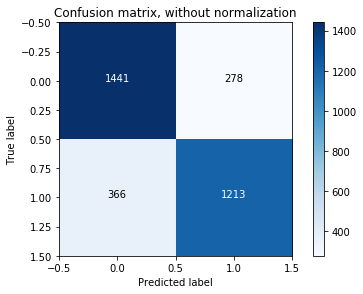

In [0]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.83827807 0.16172193]
 [0.23179227 0.76820773]]


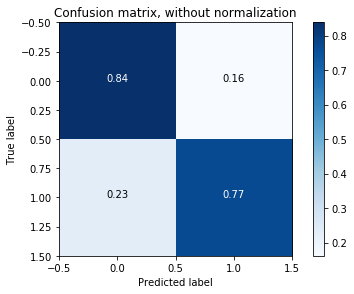

In [0]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize=True, title='Confusion matrix, without normalization')
plt.show()

# Example 2

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark MultinomialLogisticRegression classification") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [7]:
file_loc = DIR + 'WineData2.csv'
#print(file_loc)
df = spark.read.csv(file_loc, inferSchema=True, header=True)
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [8]:
df.show(5)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8|      5|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8|      6|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows



In [9]:
df.printSchema()

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free: double (nullable = true)
 |-- total: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [10]:
def string_to_float(x):
  return float(x)

def condition(r):
  if (0<=r<=4):
    label = 'low'
  elif (4<r<=6):
    label = 'medium'
  else:
    label = 'high'
  return label

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

df = df.withColumn("quality", quality_udf("quality"))

df.show(5,True)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8| medium|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8| medium|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows



In [11]:
df.printSchema()

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free: double (nullable = true)
 |-- total: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)



In [0]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
  return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [15]:
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [16]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [19]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)
data = featureIndexer.transform(transformed)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



In [20]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------+------+---------------------------------------------------------+
|features                                                 |label |indexedFeatures                                          |
+---------------------------------------------------------+------+---------------------------------------------------------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]  |low   |[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]  |
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|medium|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |medium|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |
|[5.0,1.02,0.04,1.4,0.045,41.0,85.0,0.9938,3.75,0.48,10.5]|low   |[5.0,1.02,0.04,1.4,0.045,41.0,85.0,0.9938,3.75,0.48,10.5]|
|[5.1,0.42,0.0,1.8,0.044,18.0,88.0,0.99157,3.68,0.73,13.6]|high  |[5.1,0.42,0.0,1.8,0.044,18.0,88.0,0.99157,3.68,0.73,13.6]|


In [21]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.7,0.6,0.17,2.3...|medium|        medium|
|[4.9,0.42,0.0,2.1...|  high|          high|
|[5.0,0.42,0.24,2....|  high|          high|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.0,1.04,0.24,1....|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.160828


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

Confusion matrix, without normalization
[[ 28   0  59]
 [  0   2  27]
 [ 14   1 497]]


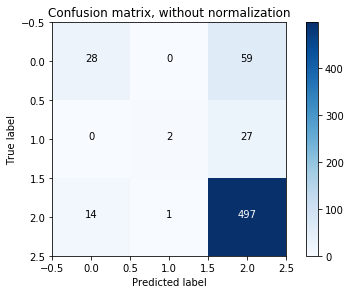

Normalized confusion matrix
[[0.32183908 0.         0.67816092]
 [0.         0.06896552 0.93103448]
 [0.02734375 0.00195312 0.97070312]]


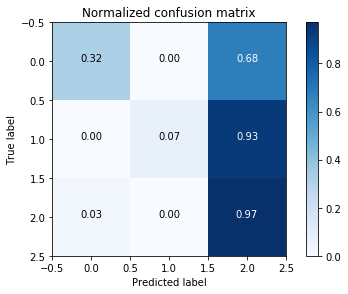

In [27]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Decision Tree

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier

# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])
model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.7,0.6,0.17,2.3...|medium|        medium|
|[4.9,0.42,0.0,2.1...|  high|          high|
|[5.0,0.42,0.24,2....|  high|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.0,1.04,0.24,1....|medium|          high|
+--------------------+------+--------------+
only showing top 5 rows



In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.154459
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_1ce88a310075) of depth 5 with 53 nodes


Confusion matrix, without normalization
[[ 47   0  40]
 [  1   1  27]
 [ 27   2 483]]


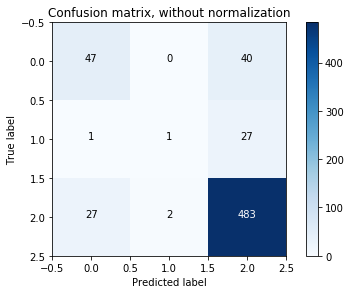

Normalized confusion matrix
[[0.54022989 0.         0.45977011]
 [0.03448276 0.03448276 0.93103448]
 [0.05273438 0.00390625 0.94335938]]


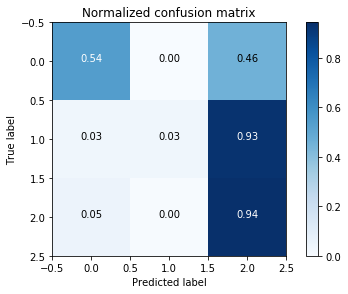

In [31]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



## Random Forest

In [32]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])
model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.7,0.6,0.17,2.3...|medium|        medium|
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,0.42,0.24,2....|  high|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.0,1.04,0.24,1....|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)

Test Error = 0.171975
RandomForestClassificationModel (uid=RandomForestClassifier_6b22420aa6fe) with 10 trees


Confusion matrix, without normalization
[[ 26   0  61]
 [  0   0  29]
 [ 18   0 494]]


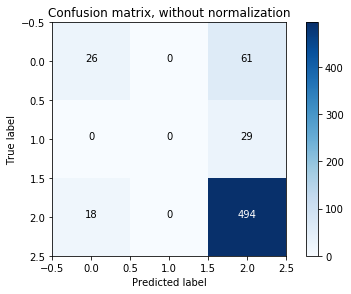

Normalized confusion matrix
[[0.29885057 0.         0.70114943]
 [0.         0.         1.        ]
 [0.03515625 0.         0.96484375]]


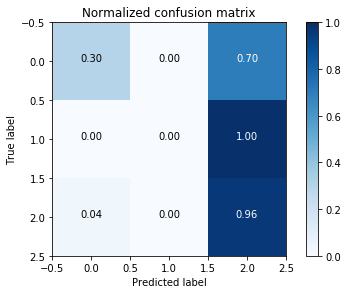

In [34]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Gradient-Boosted Tree

In [36]:
!pip install pysparkling

     |████████████████████████████████| 71kB 5.0MB/s 


In [40]:
from pysparkling import *
hc = H2OContext.getOrCreate(spark)

NameError: ignored

## Naive Bayes

In [41]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='indexedFeatures', labelCol='indexedLabel')

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb,labelConverter])
model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.7,0.6,0.17,2.3...|medium|        medium|
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,0.42,0.24,2....|  high|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.0,1.04,0.24,1....|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

#nbModel = model.stages[-2]
#print(nbModel)

Test Error = 0.353503


Confusion matrix, without normalization
[[ 56   0  31]
 [ 16   0  13]
 [162   0 350]]


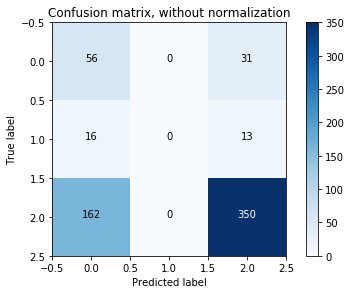

Normalized confusion matrix
[[0.64367816 0.         0.35632184]
 [0.55172414 0.         0.44827586]
 [0.31640625 0.         0.68359375]]


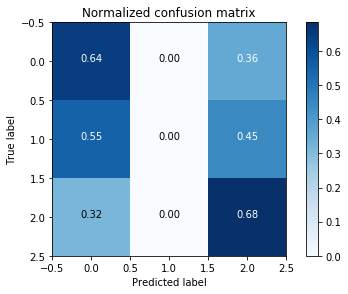

In [45]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()